# Compare RNN map & Transformer LFMCS to true observations

**Purpose:** We want to compare metrics by the RNN maps to predictions by the transformer model.

**Date:** July 29, 2024


In [234]:
from hydroDL import kPath

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import json
from sklearn.metrics import r2_score

In [198]:
# predictions paths
true_obs_dir = f'{kPath.dirVeg}predictions/true_obs_interpolate_semimonthly/' 
transformer_dir = f'{kPath.dirVeg}predictions/transformer_interpolate_semimonthly/' 
rnn_maps_dir = f'{kPath.dirVeg}predictions/rnn_maps/'


In [281]:
# get sites
sites_path = os.path.join(kPath.dirVeg, 'predictions/non_train_siteIds_both_models_all.csv')
# sites_path = os.path.join(kPath.dirVeg, 'predictions/non_train_siteIds_both_models_quality.csv')
# sites_path = os.path.join(kPath.dirVeg, 'predictions/non_train_siteIds_both_models_poor.csv')
sites = pd.read_csv(sites_path).siteId.unique()

In [282]:
# collate data
compare_df = pd.DataFrame(columns=["site", "true_lfmc", "rnn_lfmc", "transformer_lfmc"])

for site_id in sites:
    # Load site .csv files for true observation, rnn maps, transformer
    site_obs_path = f'{true_obs_dir}{site_id}.csv'
    site_rnn_path = f'{rnn_maps_dir}{site_id}.csv'
    site_transformer_path = f'{transformer_dir}{site_id}.csv'
    
    site_obs_df = pd.read_csv(site_obs_path, index_col=0)
    site_rnn_df = pd.read_csv(site_rnn_path, index_col=0)
    site_transformer_df = pd.read_csv(site_transformer_path, index_col=0)

    site_compare_df = pd.merge(site_obs_df, site_rnn_df, left_index=True, right_index=True)
    site_compare_df['true_lfmc'] = site_compare_df['lfmc_x']
    site_compare_df['rnn_lfmc'] = site_compare_df['lfmc_y']
    site_compare_df = site_compare_df.drop(['lfmc_x', 'lfmc_y'], axis=1)

    site_compare_df = pd.merge(site_compare_df, site_transformer_df, left_index=True, right_index=True)
    site_compare_df['transformer_lfmc'] = site_compare_df['lfmc']
    site_compare_df = site_compare_df.drop(['lfmc'], axis=1)
    site_compare_df = site_compare_df.dropna()
    site_compare_df = site_compare_df[site_compare_df.rnn_lfmc != 0]
    site_compare_df["site"] = [site_id for _ in range(len(site_compare_df))] 
    compare_df = pd.concat([compare_df, site_compare_df])

/var/folders/_6/xq5r06kd7qb_g5546y0zvvz80000gn/T/ipykernel_30059/1126606144.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare_df = pd.concat([compare_df, site_compare_df])


In [283]:
# get metrics
rnn_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.rnn_lfmc.astype('float')) ** 2))
rnn_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.rnn_lfmc.astype('float'))[0, 1]
rnn_coef_det = r2_score(compare_df.true_lfmc, compare_df.rnn_lfmc.astype('float'))

transformer_rmse = np.sqrt(np.mean((compare_df.true_lfmc - compare_df.transformer_lfmc) ** 2))
transformer_corr_coef = np.corrcoef(compare_df.true_lfmc, compare_df.transformer_lfmc)[0, 1]
transformer_coef_det = r2_score(compare_df.true_lfmc, compare_df.transformer_lfmc)

metric_names = ["rmse", "correlation coefficient", "coefficient of determination"]
rnn_metrics = [rnn_rmse, rnn_corr_coef, rnn_coef_det]
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

metrics_dict = {
    "metrics" : metric_names,
    "rnn" : rnn_metrics,
    "transformer" : transformer_metrics
}

metrics = pd.DataFrame(metrics_dict)
metrics

,metrics,rnn,transformer
0,rmse,43.788963,30.584842
1,correlation coefficient,0.259902,0.616920
2,coefficient of determination,-0.346549,0.343091


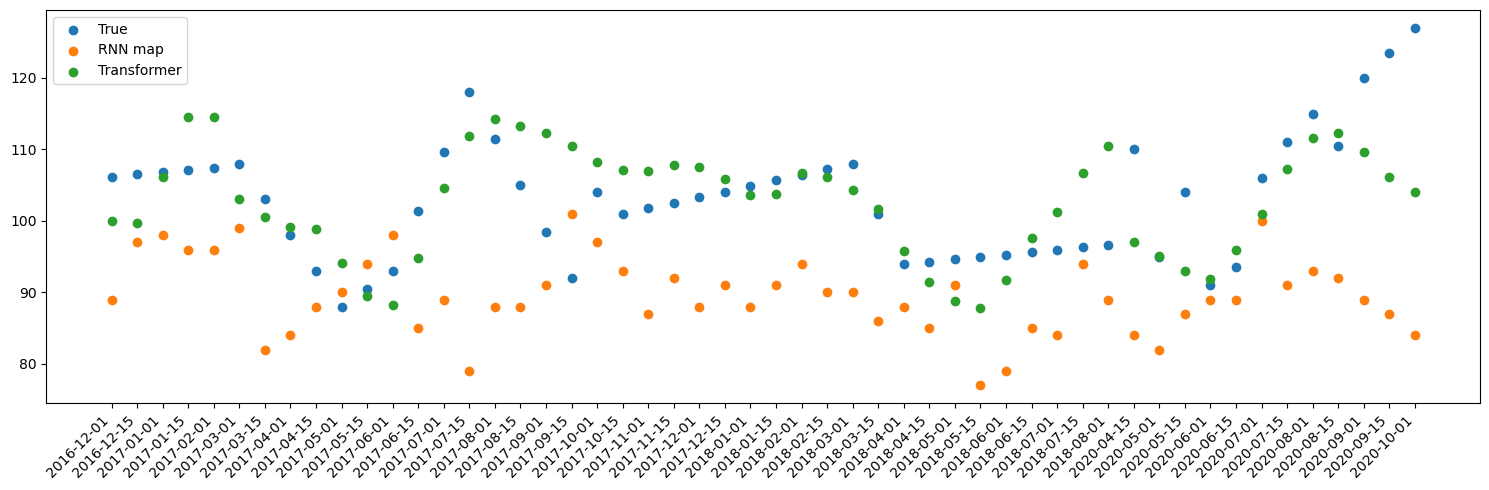

In [290]:
# get time series of given site
site_id = 4
sub_compare_df = compare_df[compare_df.site == sites[site_id]]

plt.figure(figsize=(15, 5))
plt.scatter(sub_compare_df.index, sub_compare_df.true_lfmc)
plt.scatter(sub_compare_df.index, sub_compare_df.rnn_lfmc)
plt.scatter(sub_compare_df.index, sub_compare_df.transformer_lfmc)

plt.legend(["True", "RNN map", "Transformer"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

### Transformer daily stats

In [259]:
path = os.path.join(kPath.dirVeg, "predictions/transformer_lfmc_daily.csv")
transformer_daily_df = pd.read_csv(path)

path = os.path.join(kPath.dirVeg, "NFMD/NFMD.csv")
true_daily_df = pd.read_csv(path)

In [260]:
daily_df = pd.merge(transformer_daily_df, true_daily_df, left_on=["site", "date"], right_on=["siteId", "Date"])

transformer_rmse = np.sqrt(np.mean((daily_df.lfmc - daily_df.Percent) ** 2))
transformer_corr_coef = np.corrcoef(daily_df.lfmc, daily_df.Percent)[0, 1]
transformer_coef_det = r2_score(daily_df.lfmc, daily_df.Percent)
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

daily_metrics_dict = {
    "metrics" : metric_names,
    "transformer" : transformer_metrics
}

daily_metrics = pd.DataFrame(daily_metrics_dict)
daily_metrics

,metrics,transformer
0,rmse,22.687895
1,correlation coefficient,0.844393
2,coefficient of determination,0.599314


In [261]:
# get quality and poor sites
path = os.path.join(kPath.dirVeg, "model/data/singleDaily-nadgrid/site.csv")
site_df = pd.read_csv(path)

splits_path = os.path.join(kPath.dirVeg, 'model', 'attention', 'dataset')
splits_json = os.path.join(splits_path, 'subset.json')

with open(splits_json) as json_file:
    splits = json.load(json_file)

quality_test_sites = splits['testSite_k05']
poor_test_sites = splits['testSite_underThresh']

quality_sites = site_df.iloc[quality_test_sites].siteId.tolist()
poor_sites = site_df.iloc[poor_test_sites].siteId.tolist()


In [262]:
sub_daily_df = daily_df[daily_df.site.isin(quality_sites)]

transformer_rmse = np.sqrt(np.mean((sub_daily_df.lfmc - sub_daily_df.Percent) ** 2))
transformer_corr_coef = np.corrcoef(sub_daily_df.lfmc, sub_daily_df.Percent)[0, 1]
transformer_coef_det = r2_score(sub_daily_df.lfmc, sub_daily_df.Percent)
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

daily_metrics_dict = {
    "metrics" : metric_names,
    "transformer" : transformer_metrics
}

daily_metrics = pd.DataFrame(daily_metrics_dict)
daily_metrics

,metrics,transformer
0,rmse,17.414221
1,correlation coefficient,0.912409
2,coefficient of determination,0.798819


In [263]:
sub_daily_df = daily_df[daily_df.site.isin(poor_sites)]

transformer_rmse = np.sqrt(np.mean((sub_daily_df.lfmc - sub_daily_df.Percent) ** 2))
transformer_corr_coef = np.corrcoef(sub_daily_df.lfmc, sub_daily_df.Percent)[0, 1]
transformer_coef_det = r2_score(sub_daily_df.lfmc, sub_daily_df.Percent)
transformer_metrics = [transformer_rmse, transformer_corr_coef, transformer_coef_det]

daily_metrics_dict = {
    "metrics" : metric_names,
    "transformer" : transformer_metrics
}

daily_metrics = pd.DataFrame(daily_metrics_dict)
daily_metrics

,metrics,transformer
0,rmse,26.099252
1,correlation coefficient,0.784638
2,coefficient of determination,0.380525


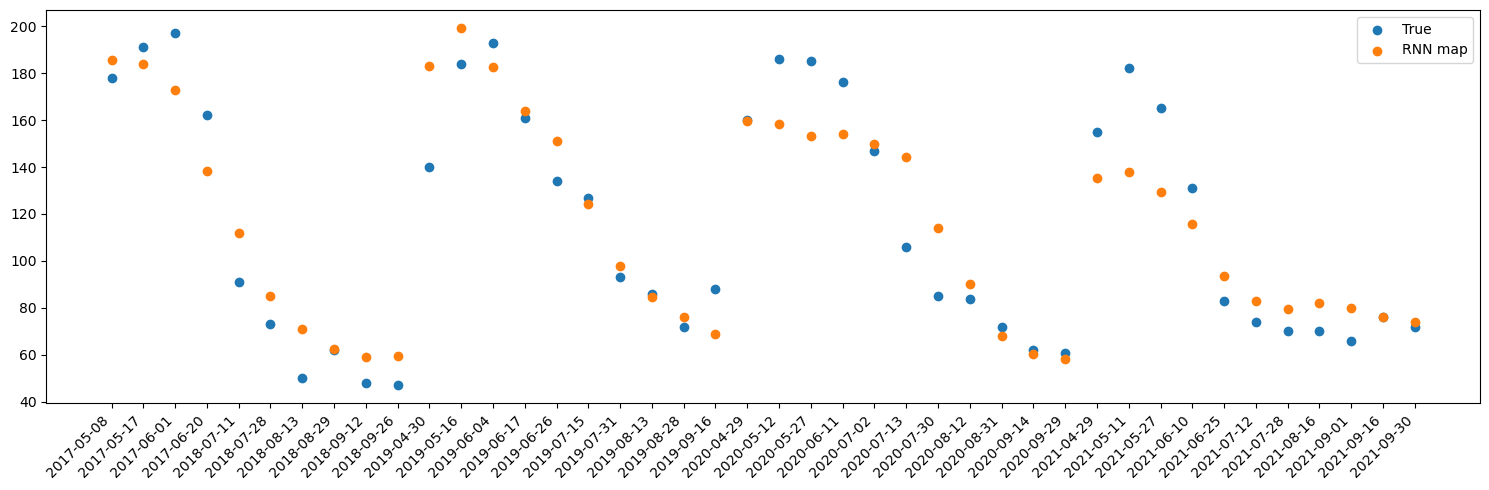

In [268]:
# get time series of given site
site_idx = 10
sub_daily_df = daily_df[daily_df.site == quality_sites[site_idx]]

plt.figure(figsize=(15, 5))
plt.scatter(sub_daily_df.Date, sub_daily_df.Percent)
plt.scatter(sub_daily_df.Date, sub_daily_df.lfmc)

plt.legend(["True", "RNN map", "Transformer"])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

### Exta

In [106]:
compare_df["rnn_diff"] = abs(compare_df.true_lfmc - compare_df.rnn_lfmc)
compare_df["transformer_diff"] = abs(compare_df.true_lfmc - compare_df.transformer_lfmc)

In [107]:
diff_by_site = compare_df.groupby("site").mean()

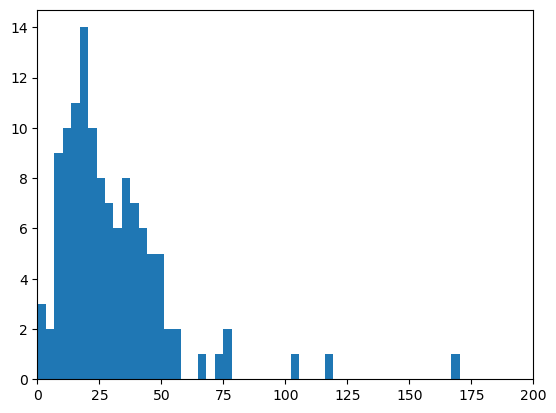

In [108]:
plt.hist(diff_by_site.rnn_diff, bins=50)
plt.xlim(0, 200)
plt.show()

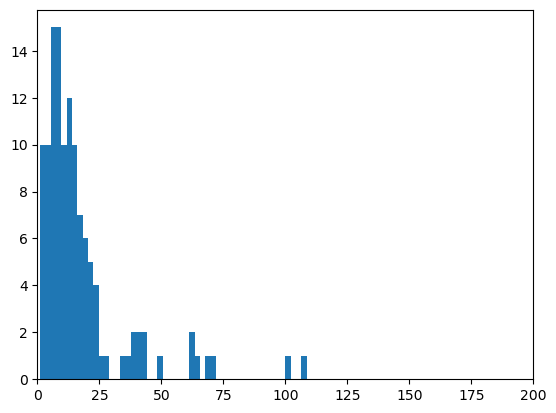

In [109]:
plt.hist(diff_by_site.transformer_diff, bins=50)
plt.xlim(0, 200)
plt.show()